# Tornado tracks and initial points: 1955-2022

#### Import Python tools

In [7]:
import io
import us
import jupyter_black
import pandas as pd
import geopandas as gpd
import numpy as np
import altair as alt
import altair_stiles as altstiles
import requests
import json
import jenkspy
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.patches as mpatches
import shapely.geometry as sgeom
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import calendar
from zipfile import ZipFile

In [4]:
jupyter_black.load()
pd.options.display.max_columns = 100
pd.options.display.max_rows = 1000
pd.options.display.max_colwidth = None
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [5]:
today = pd.Timestamp("today").strftime("%m/%d/%Y")

---

## Geography

#### States

In [8]:
states = gpd.read_file("data/raw/usa_states_shp/usa_states_esri_mainland.shp")

In [9]:
states_mainland = states[~states["STATE_ABBR"].isin(["HI", "AK", "VI", "PR"])]

#### Cities

In [12]:
cities = gpd.read_file("data/raw/USA_Major_Cities.geojson")[
    ["NAME", "ST", "CAPITAL", "POPULATION", "geometry"]
]

In [13]:
cities.columns = cities.columns.str.lower()

---

## Tracks

#### Past tornado [tracks](https://www.spc.noaa.gov/gis/svrgis/) from the National Weather Service | [metadata](https://www.spc.noaa.gov/wcm/data/SPC_severe_database_description.pdf)

In [16]:
tracks_df = gpd.read_file(
    "data/raw/1950-2022-torn-aspath/1950-2022-torn-aspath.shp",
)

In [17]:
tracks_df = tracks_df[(tracks_df["mag"] != -9) & (tracks_df["mag"] != 0)].copy()

In [18]:
tracks_df["mag"] = tracks_df["mag"].astype(str)

#### Add month names

In [19]:
tracks_df["month"] = tracks_df["mo"].apply(lambda x: calendar.month_abbr[x])

In [20]:
tracks_df.head()

,om,yr,mo,dy,date,time,tz,st,stf,stn,mag,inj,fat,loss,closs,slat,slon,elat,elon,len,wid,fc,geometry,month
0,192,1950,10,1,1950-10-01,21:00:00,3,OK,40,23,1,0,0,4.0,0.0,36.73,-102.52,36.8800,-102.3000,15.8,10,0,"LINESTRING (-102.52000 36.73000, -102.30000 36.88000)",Oct
1,193,1950,10,9,1950-10-09,02:15:00,3,NC,37,9,3,3,0,5.0,0.0,34.17,-78.60,34.1701,-78.5999,2.0,880,0,"LINESTRING (-78.60000 34.17000, -78.59990 34.17010)",Oct
2,195,1950,11,20,1950-11-20,02:20:00,3,KY,21,1,2,0,0,5.0,0.0,37.37,-87.20,37.3701,-87.1999,0.1,10,0,"LINESTRING (-87.20000 37.37000, -87.19990 37.37010)",Nov
3,196,1950,11,20,1950-11-20,04:00:00,3,KY,21,2,1,0,0,5.0,0.0,38.20,-84.50,38.2001,-84.4999,0.1,10,0,"LINESTRING (-84.50000 38.20000, -84.49990 38.20010)",Nov
4,197,1950,11,20,1950-11-20,07:30:00,3,MS,28,14,1,3,0,4.0,0.0,32.42,-89.13,32.4201,-89.1299,2.0,37,0,"LINESTRING (-89.13000 32.42000, -89.12990 32.42010)",Nov


#### Dates/times

In [23]:
tracks_df["date"] = pd.to_datetime(tracks_df["date"], format="%Y-%m-%d")
tracks_df["hour"] = pd.to_datetime(tracks_df["time"], format="%H:%M:%S").dt.hour
tracks_df["timeclean"] = pd.to_datetime(tracks_df["time"], format="%H:%M:%S").dt.time

#### Create a decade field

In [24]:
tracks_df["decade"] = tracks_df["yr"].astype(str).str[:3] + "0s"

#### Exclude Alaska, Hawaii, Puerto Rico and Virgin Islands

In [25]:
mainland_tracks = tracks_df[~tracks_df["st"].isin(["HI", "AK", "VI", "PR"])]

---

#### Overnight storms

In [26]:
nocturnal = mainland_tracks[
    (mainland_tracks["hour"] > 20) | (mainland_tracks["hour"] < 5)
]

In [27]:
nocturnal.head()

,om,yr,mo,dy,date,time,tz,st,stf,stn,mag,inj,fat,loss,closs,slat,slon,elat,elon,len,wid,fc,geometry,month,hour,timeclean,decade
0,192,1950,10,1,1950-10-01,21:00:00,3,OK,40,23,1,0,0,4.0,0.0,36.73,-102.52,36.8800,-102.3000,15.8,10,0,"LINESTRING (-102.52000 36.73000, -102.30000 36.88000)",Oct,21,21:00:00,1950s
1,193,1950,10,9,1950-10-09,02:15:00,3,NC,37,9,3,3,0,5.0,0.0,34.17,-78.60,34.1701,-78.5999,2.0,880,0,"LINESTRING (-78.60000 34.17000, -78.59990 34.17010)",Oct,2,02:15:00,1950s
2,195,1950,11,20,1950-11-20,02:20:00,3,KY,21,1,2,0,0,5.0,0.0,37.37,-87.20,37.3701,-87.1999,0.1,10,0,"LINESTRING (-87.20000 37.37000, -87.19990 37.37010)",Nov,2,02:20:00,1950s
3,196,1950,11,20,1950-11-20,04:00:00,3,KY,21,2,1,0,0,5.0,0.0,38.20,-84.50,38.2001,-84.4999,0.1,10,0,"LINESTRING (-84.50000 38.20000, -84.49990 38.20010)",Nov,4,04:00:00,1950s
12,6,1950,1,25,1950-01-25,21:00:00,3,IL,17,3,2,0,0,5.0,0.0,41.17,-87.33,41.1701,-87.3299,0.1,100,0,"LINESTRING (-87.33000 41.17000, -87.32990 41.17010)",Jan,21,21:00:00,1950s


#### With at least one death

In [28]:
nocturnal_fat = nocturnal[nocturnal["fat"] >= 1]

---

#### Seasonal trends

> Tornado season usually refers to the time of year the U.S. sees the most tornadoes. The peak “tornado season” for the southern Plains (e.g., Texas, Oklahoma, and Kansas) is from May into early June. On the Gulf coast, it is earlier in the spring. In the northern Plains and upper Midwest (North and South Dakota, Nebraska, Iowa, Minnesota), tornado season is in June or July. But, remember, tornadoes can happen at any time of year. Tornadoes can also happen at any time of day or night, but most tornadoes occur between 4–9 p.m.

In [29]:
mainland_tracks.head()

,om,yr,mo,dy,date,time,tz,st,stf,stn,mag,inj,fat,loss,closs,slat,slon,elat,elon,len,wid,fc,geometry,month,hour,timeclean,decade
0,192,1950,10,1,1950-10-01,21:00:00,3,OK,40,23,1,0,0,4.0,0.0,36.73,-102.52,36.8800,-102.3000,15.8,10,0,"LINESTRING (-102.52000 36.73000, -102.30000 36.88000)",Oct,21,21:00:00,1950s
1,193,1950,10,9,1950-10-09,02:15:00,3,NC,37,9,3,3,0,5.0,0.0,34.17,-78.60,34.1701,-78.5999,2.0,880,0,"LINESTRING (-78.60000 34.17000, -78.59990 34.17010)",Oct,2,02:15:00,1950s
2,195,1950,11,20,1950-11-20,02:20:00,3,KY,21,1,2,0,0,5.0,0.0,37.37,-87.20,37.3701,-87.1999,0.1,10,0,"LINESTRING (-87.20000 37.37000, -87.19990 37.37010)",Nov,2,02:20:00,1950s
3,196,1950,11,20,1950-11-20,04:00:00,3,KY,21,2,1,0,0,5.0,0.0,38.20,-84.50,38.2001,-84.4999,0.1,10,0,"LINESTRING (-84.50000 38.20000, -84.49990 38.20010)",Nov,4,04:00:00,1950s
4,197,1950,11,20,1950-11-20,07:30:00,3,MS,28,14,1,3,0,4.0,0.0,32.42,-89.13,32.4201,-89.1299,2.0,37,0,"LINESTRING (-89.13000 32.42000, -89.12990 32.42010)",Nov,7,07:30:00,1950s


In [30]:
months_grouped = (
    mainland_tracks[mainland_tracks["yr"] > 2002]
    .groupby(["mo", "month"])
    .agg({"om": "size", "inj": "sum", "fat": "sum"})
    .reset_index()
    .rename(columns={"om": "all_count", "inj": "all_injuries", "fat": "all_fatalities"})
)

In [31]:
months_grouped_night = (
    nocturnal[nocturnal["yr"] > 2002]
    .groupby(["mo", "month"])
    .agg({"om": "size", "inj": "sum", "fat": "sum"})
    .reset_index()
    .rename(
        columns={
            "om": "night_count",
            "inj": "night_injuries",
            "fat": "night_fatalities",
        }
    )
)

In [32]:
months_grouped_night

,mo,month,night_count,night_injuries,night_fatalities
0,1,Jan,135,278,26
1,2,Feb,154,448,71
2,3,Mar,210,743,49
3,4,Apr,485,563,42
4,5,May,395,368,41
5,6,Jun,191,84,9
6,7,Jul,94,39,1
7,8,Aug,81,107,6
8,9,Sep,74,26,2
9,10,Oct,117,42,3


In [33]:
months_grouped

,mo,month,all_count,all_injuries,all_fatalities
0,1,Jan,432,560,47
1,2,Feb,475,1317,129
2,3,Mar,983,1788,163
3,4,Apr,2080,6054,535
4,5,May,2129,4304,361
5,6,Jun,1178,694,32
6,7,Jul,641,196,9
7,8,Aug,523,355,15
8,9,Sep,482,189,16
9,10,Oct,529,203,12


In [34]:
months_time = pd.merge(months_grouped, months_grouped_night, on=["mo", "month"])

In [35]:
# months_time["night_count_share"] = (
#     (months_time["night_count"] / months_time["all_count"]) * 100
# ).round(0)

In [36]:
# months_time["night_injuries_share"] = (
#     (months_time["night_injuries"] / months_time["all_injuries"]) * 100
# ).round(0)

In [37]:
# months_time["night_fatalities_share"] = (
#     (months_time["night_fatalities"] / months_time["all_fatalities"]) * 100
# ).round(0)

In [38]:
months_time["all_count_share"] = (
    (months_time["all_count"] / months_time["all_count"].sum()) * 100
).round(0)

In [39]:
months_time["all_injuries_share"] = (
    (months_time["all_injuries"] / months_time["all_injuries"].sum()) * 100
).round(0)

In [40]:
months_time["all_fatalities_share"] = (
    (months_time["all_fatalities"] / months_time["all_fatalities"].sum()) * 100
).round(0)

In [44]:
months_time[
    [
        "mo",
        "month",
        "all_count",
        "all_injuries",
        "all_fatalities",
        "night_count",
        "night_injuries",
        "night_fatalities",
        "all_count_share",
        "all_injuries_share",
        "all_fatalities_share",
    ]
]

,month,all_count,all_injuries,all_fatalities,night_count,night_injuries,night_fatalities,all_count_share,all_injuries_share,all_fatalities_share
0,Jan,432,560,47,135,278,26,4.0,3.0,3.0
1,Feb,475,1317,129,154,448,71,4.0,7.0,8.0
2,Mar,983,1788,163,210,743,49,9.0,10.0,11.0
3,Apr,2080,6054,535,485,563,42,20.0,33.0,35.0
4,May,2129,4304,361,395,368,41,20.0,23.0,24.0
5,Jun,1178,694,32,191,84,9,11.0,4.0,2.0
6,Jul,641,196,9,94,39,1,6.0,1.0,1.0
7,Aug,523,355,15,81,107,6,5.0,2.0,1.0
8,Sep,482,189,16,74,26,2,5.0,1.0,1.0
9,Oct,529,203,12,117,42,3,5.0,1.0,1.0


In [ ]:
months_time.to_csv(
    "data/processed/tornadoes_count_injuries_deaths_times_2002-2021.csv", index=False
)

In [ ]:
months_grouped.to_csv(
    "data/processed/tornadoes_count_injuries_deaths_2002-2021.csv", index=False
)

In [45]:
months_years_grouped = (
    mainland_tracks[mainland_tracks["yr"] >= 2002]
    .groupby(["mo", "yr"])
    .agg({"om": "size", "inj": "sum", "fat": "sum"})
    .reset_index()
    .rename(columns={"om": "count", "inj": "injuries", "fat": "fatalities"})
)

In [46]:
len(months_years_grouped)

248

In [47]:
alt.Chart(months_years_grouped).mark_bar().encode(
    x=alt.X("mo:O", title=" "),
    y=alt.Y("count", title=""),
    facet=alt.Facet("yr", columns=5, title=""),
).properties(
    width=150, height=100, title="Tornado count by month and year in last 20 years"
)

alt.Chart(...)

---

In [48]:
breaks = jenkspy.jenks_breaks(list(mainland_tracks.fat.astype(int)), n_classes=5)
breaks

[0, 2, 13, 38, 80, 158]

In [49]:
cmap = ListedColormap(["#fef0d9", "#fdcc8a", "#fc8d59", "#e34a33", "#b30000"])
cmap_alt = ListedColormap(["#000000"])

In [50]:
decades = mainland_tracks.decade.sort_values().unique()
decades

array(['1950s', '1960s', '1970s', '1980s', '1990s', '2000s', '2010s',
       '2020s'], dtype=object)

In [51]:
nocturnal_recent = nocturnal[nocturnal["yr"] > 2000]
years = nocturnal_recent.yr.sort_values().unique()
years

array([2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022])

In [52]:
albo = ccrs.AlbersEqualArea(
    central_longitude=-96,
    central_latitude=37.5,
    false_easting=0.0,
    false_northing=0.0,
    standard_parallels=(29.5, 45.5),
    globe=None,
)

In [53]:
mainland_tracks.head()

,om,yr,mo,dy,date,time,tz,st,stf,stn,mag,inj,fat,loss,closs,slat,slon,elat,elon,len,wid,fc,geometry,month,hour,timeclean,decade
0,192,1950,10,1,1950-10-01,21:00:00,3,OK,40,23,1,0,0,4.0,0.0,36.73,-102.52,36.8800,-102.3000,15.8,10,0,"LINESTRING (-102.52000 36.73000, -102.30000 36.88000)",Oct,21,21:00:00,1950s
1,193,1950,10,9,1950-10-09,02:15:00,3,NC,37,9,3,3,0,5.0,0.0,34.17,-78.60,34.1701,-78.5999,2.0,880,0,"LINESTRING (-78.60000 34.17000, -78.59990 34.17010)",Oct,2,02:15:00,1950s
2,195,1950,11,20,1950-11-20,02:20:00,3,KY,21,1,2,0,0,5.0,0.0,37.37,-87.20,37.3701,-87.1999,0.1,10,0,"LINESTRING (-87.20000 37.37000, -87.19990 37.37010)",Nov,2,02:20:00,1950s
3,196,1950,11,20,1950-11-20,04:00:00,3,KY,21,2,1,0,0,5.0,0.0,38.20,-84.50,38.2001,-84.4999,0.1,10,0,"LINESTRING (-84.50000 38.20000, -84.49990 38.20010)",Nov,4,04:00:00,1950s
4,197,1950,11,20,1950-11-20,07:30:00,3,MS,28,14,1,3,0,4.0,0.0,32.42,-89.13,32.4201,-89.1299,2.0,37,0,"LINESTRING (-89.13000 32.42000, -89.12990 32.42010)",Nov,7,07:30:00,1950s


In [54]:
nocturnal = nocturnal.to_crs(albo.proj4_init)
nocturnal_recent = nocturnal_recent.to_crs(albo.proj4_init)
mainland_tracks = mainland_tracks.to_crs(albo.proj4_init)
states_mainland = states_mainland.to_crs(albo.proj4_init)

/Users/mstiles/.local/share/virtualenvs/cnn-visuals-notebooks-4cYBYQKl/lib/python3.9/site-packages/geopandas/plotting.py:397: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=figsize)


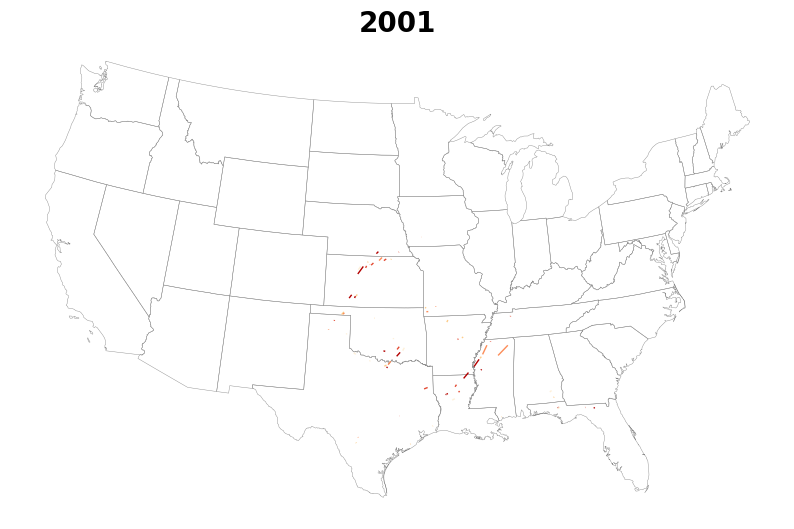

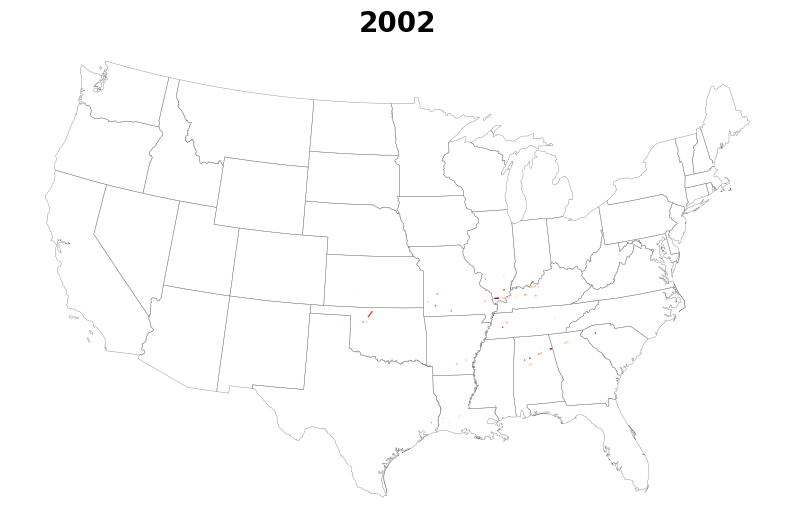

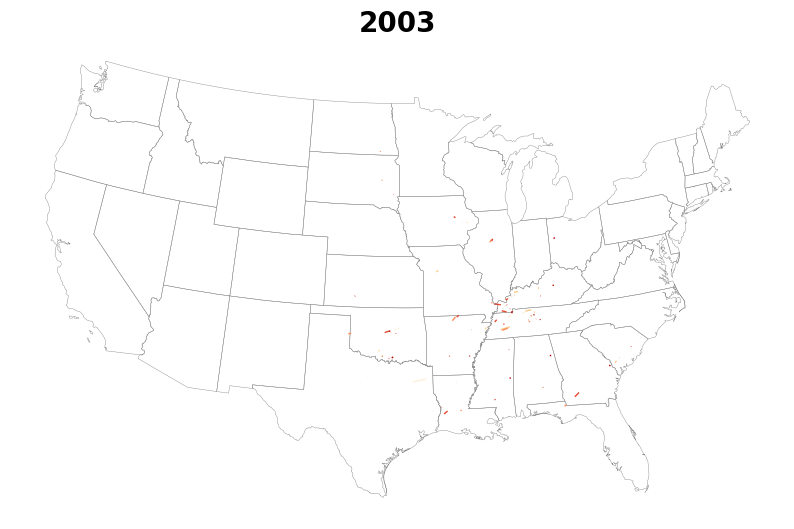

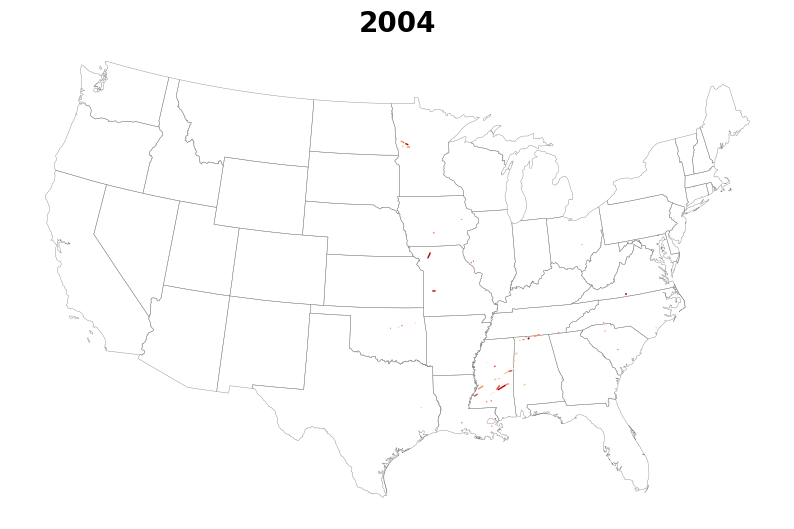

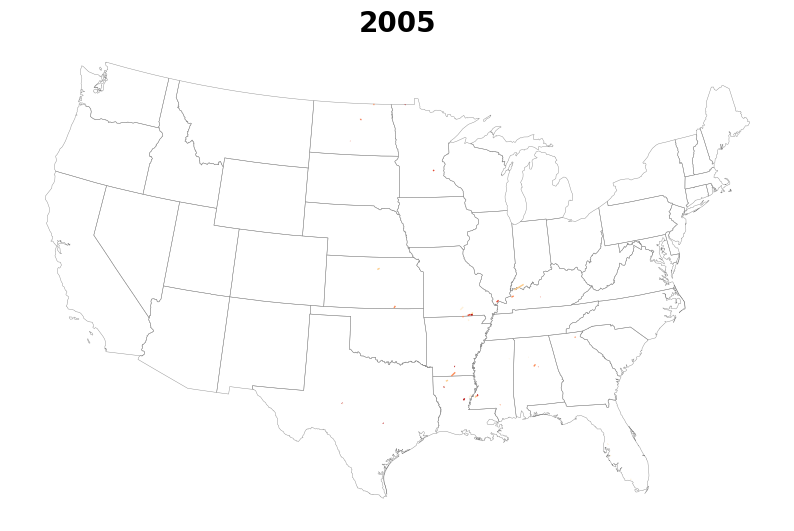

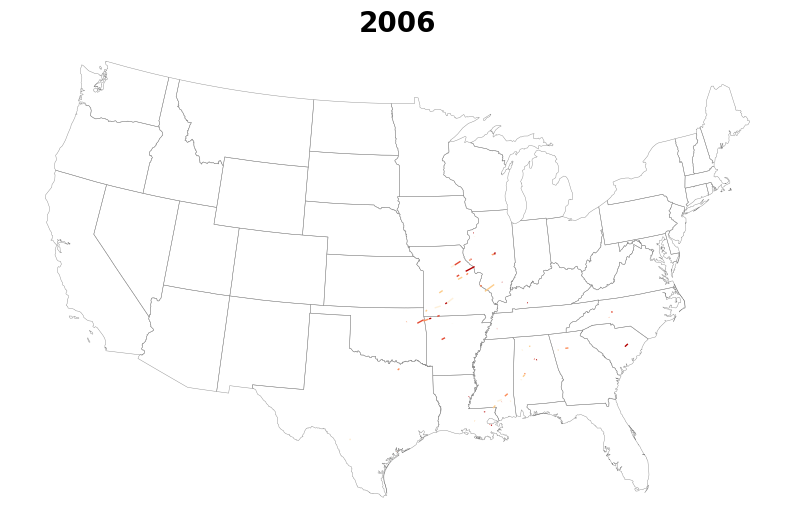

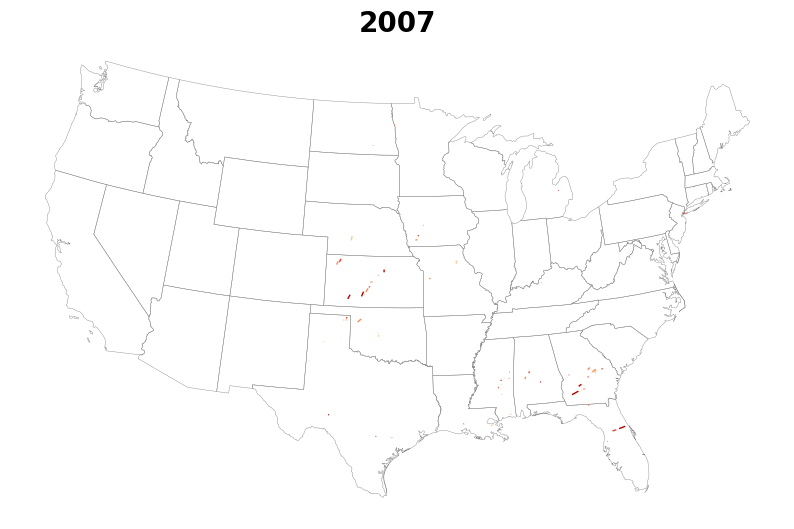

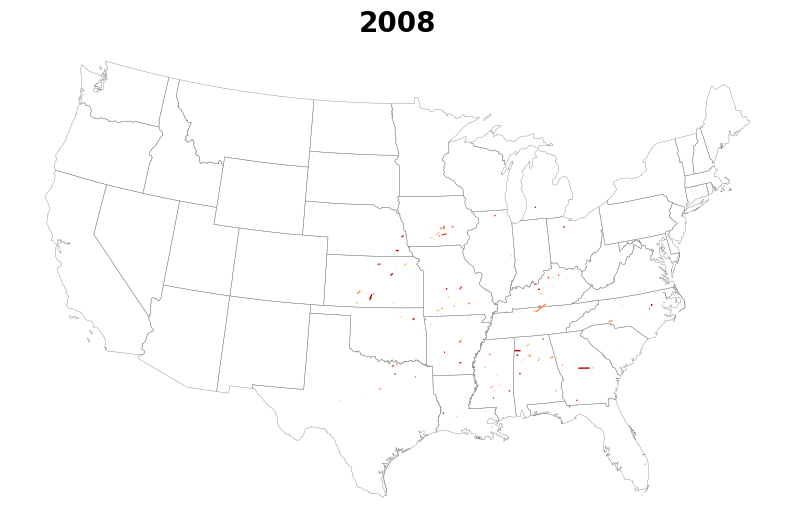

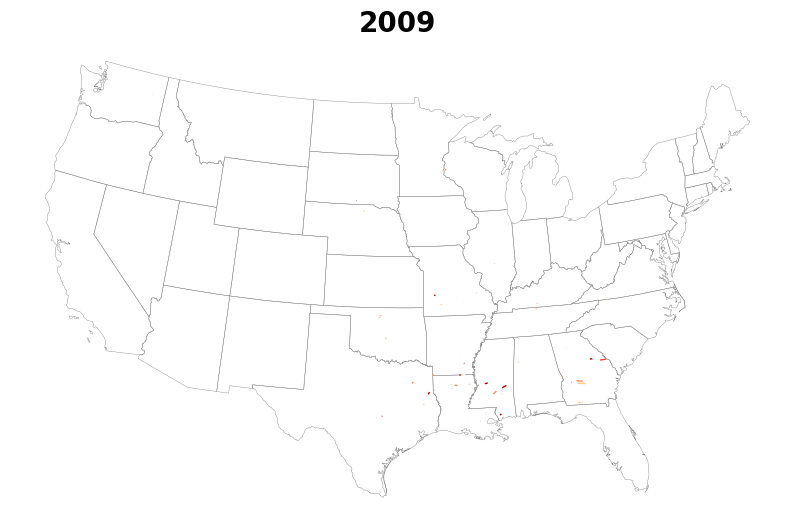

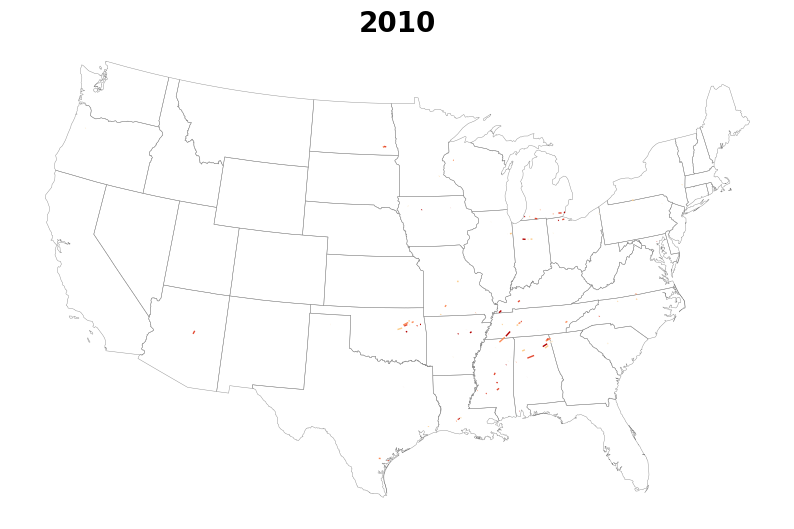

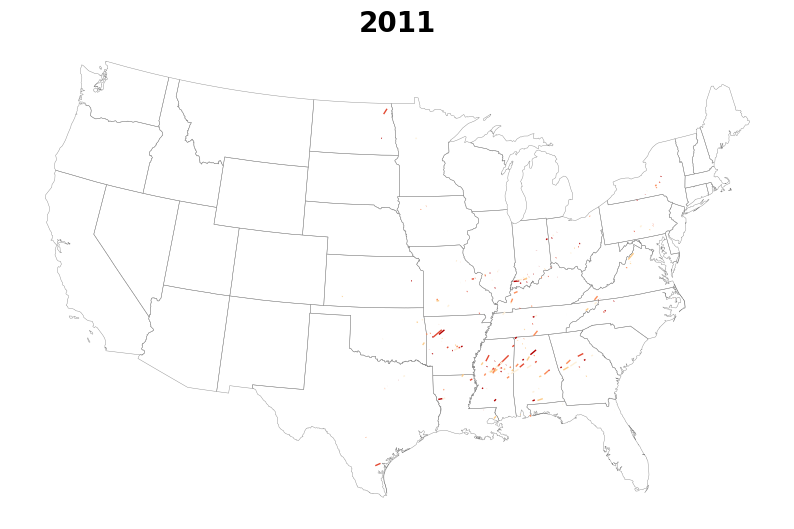

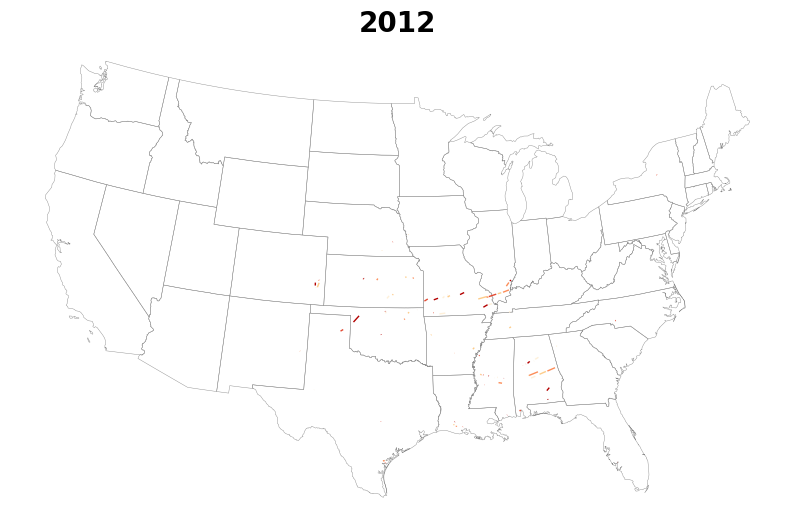

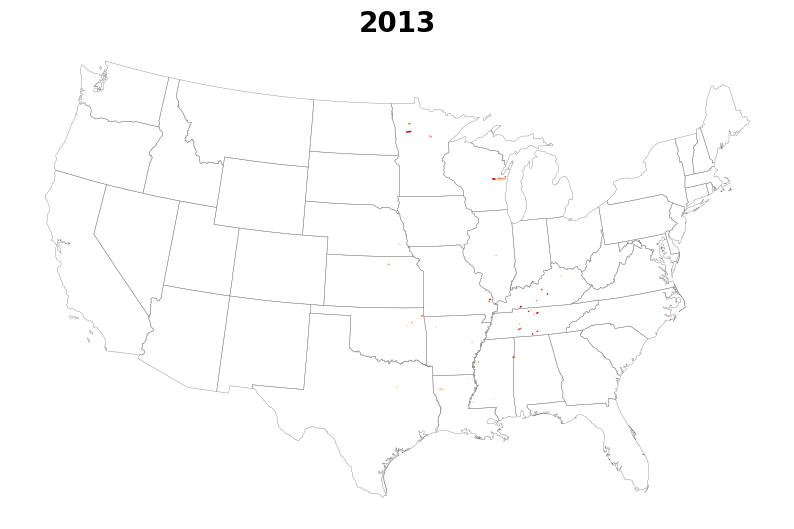

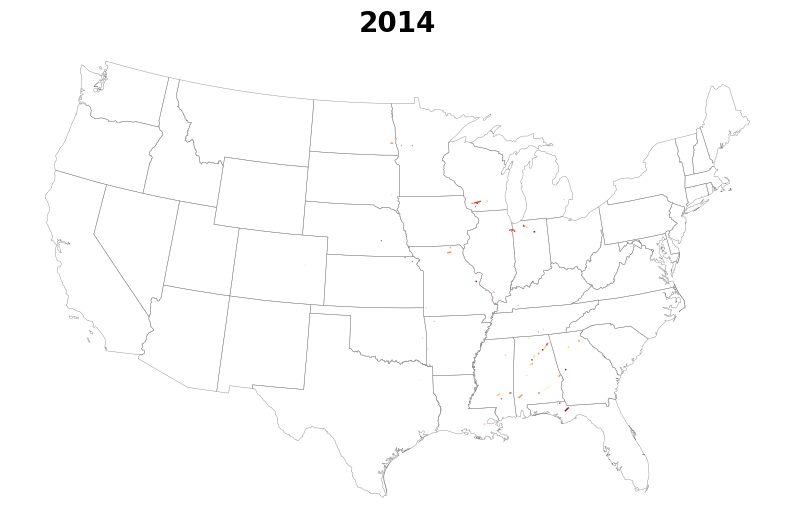

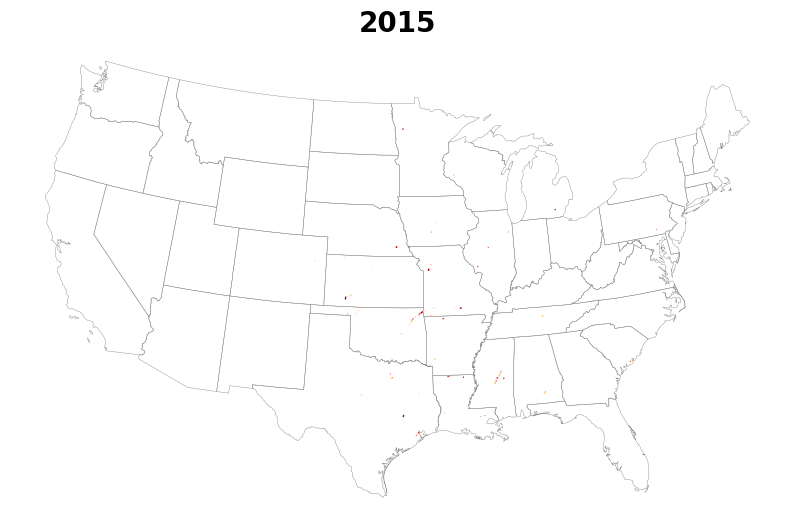

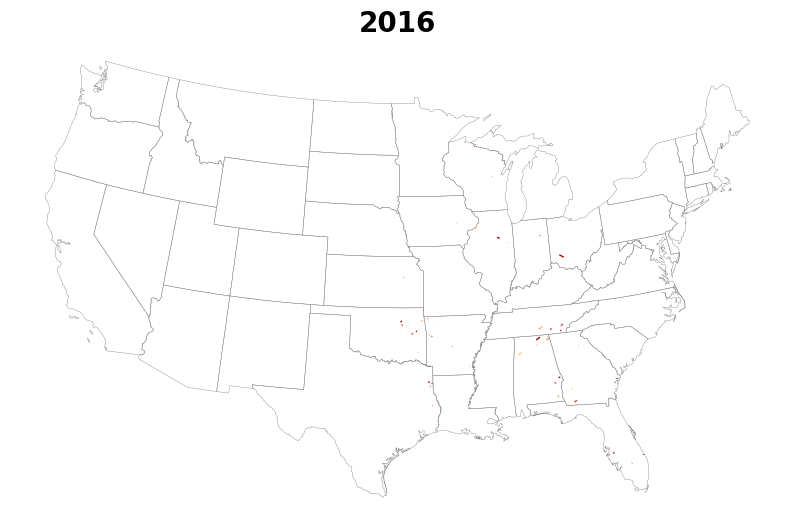

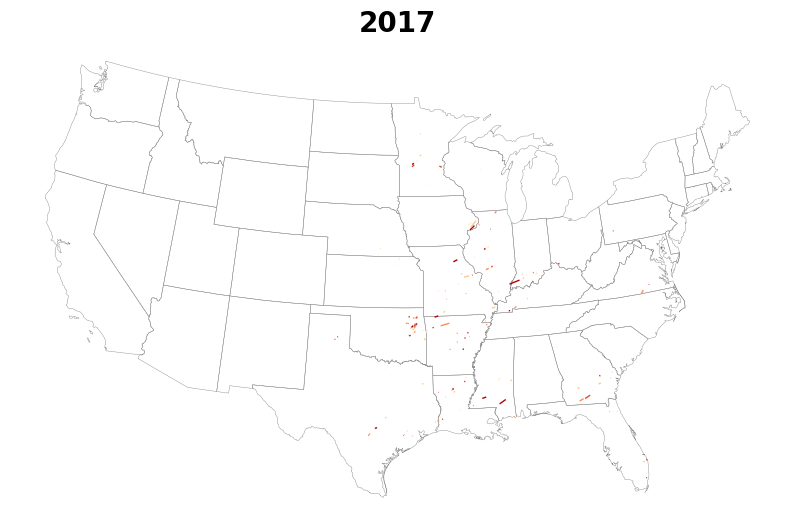

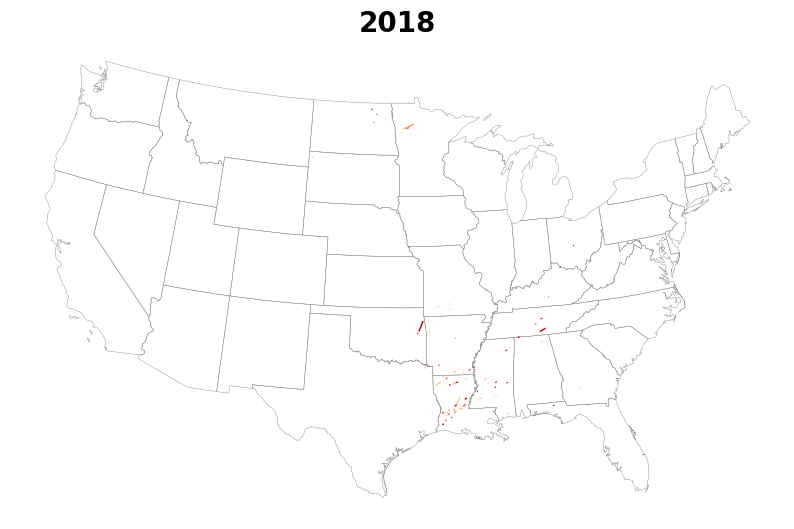

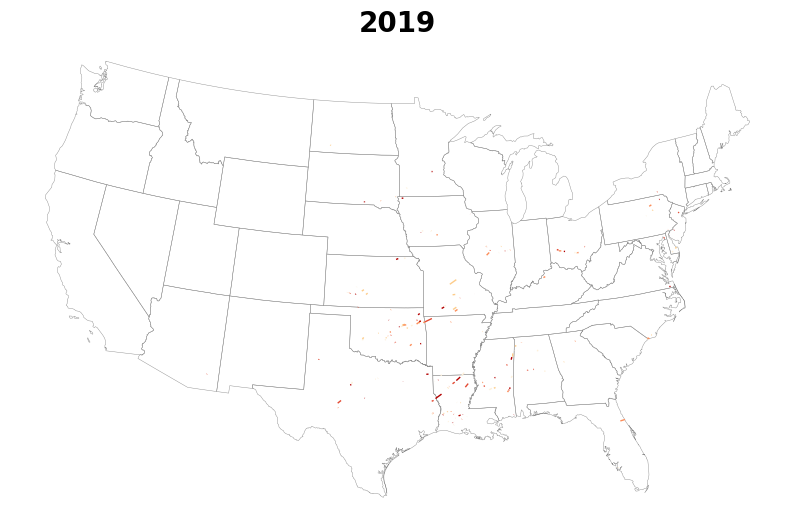

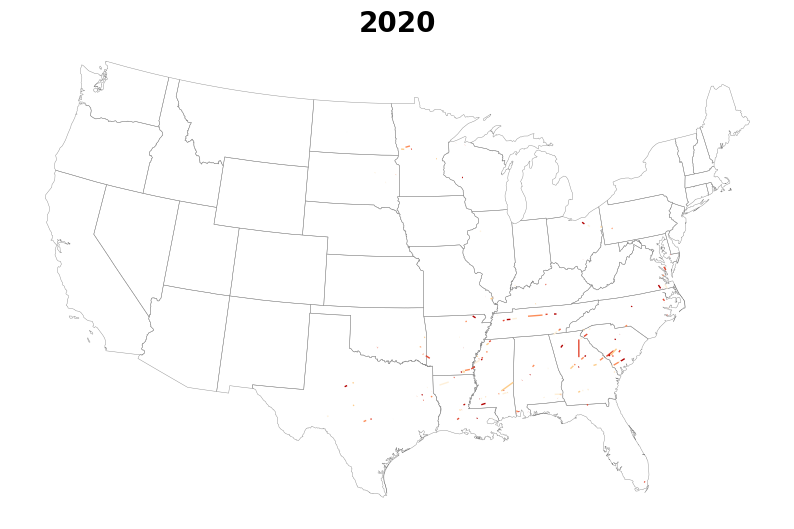

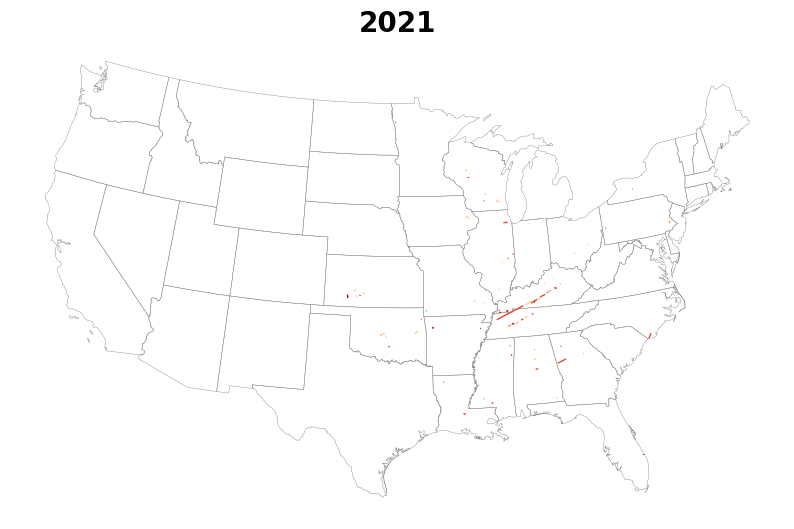

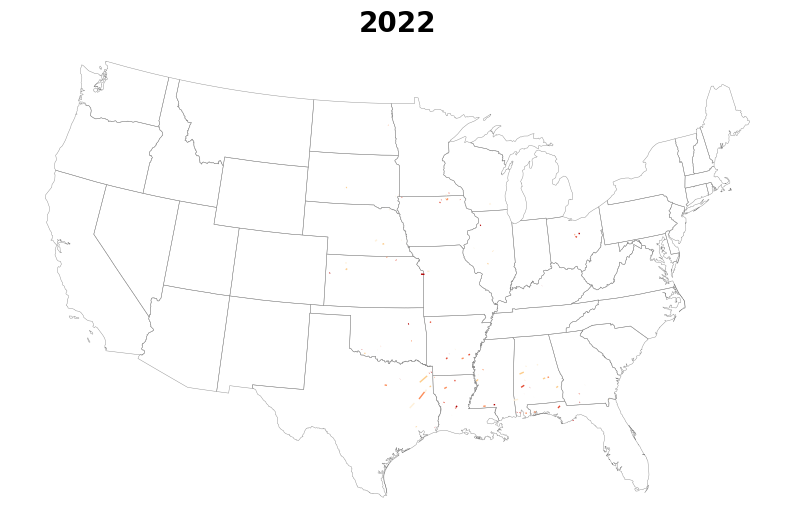

In [55]:
for y in years:

    ax = nocturnal[(nocturnal["yr"] == y)].boundary.plot(
        edgecolor="white",
        linewidth=0,
        markersize=0,
        figsize=(10, 7),
    )

    nocturnal[nocturnal["yr"] == y].plot(
        ax=ax,
        legend=False,
        categorical=True,
        cmap=cmap,
        scheme="User_Defined",
        linewidth=1,
        classification_kwds=dict(bins=breaks),
    )

    states_mainland.plot(ax=ax, facecolor="none", edgecolor="#888", linewidth=0.3)

    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    for edge in ["right", "bottom", "top", "left"]:
        ax.spines[edge].set_visible(False)

    ax.set_title(
        f"{y}",
        font="CNN Sans",
        size=20,
        weight="bold",
    )

    # plt.savefig(
    #     f"visuals/map_2050_after.svg",
    #     dpi=72,
    #     transparent=True,
    #     pad_inches=0,
    #     bbox_inches="tight",
    # )